In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline

# Read CSV
data = pd.read_csv('OnlineNewsPopularity_ForModeling.csv',index_col='url')

In [21]:
def predict(probability, threshold=0.5):
    '''Makes prediction based on given probability threshold'''
    List = []
    for prob in probability:
        if prob > threshold:
            List.append(1)
        if prob <= threshold:
            List.append(0)
    return np.array(List)

def plot_confusion_matrix(cm,classes,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    Prints and plots a confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def popularity(data,thresh,col_name):
    """
    Labels data as 'popular' or 'unpopular' based on a given threshold.
    """
    data.loc[data[(data['shares'] > thresh)].index,col_name] = 'popular'
    data.loc[data[data['shares'] <= thresh].index,col_name] = 'unpopular'
    return data.drop(columns='shares')

def lim_entries(X,y,i=None,print_y=False):
    '''
    Limits the points in the training set such that all all labels are equal.
    Adds cut points to the testing set. 
    '''
    if type(X) == tuple:
        X_train, X_test = X[0],X[1]
        y_train, y_test = y[0],y[1]
    
        if i == 0:
            return X_train, X_test, y_train, y_test

        y_var = y_train.name
        data = X_train.join(y_train)
        entries = list(data[y_var].value_counts().index[:-1])
        n = list(data[y_var].value_counts())[-1]*i
        new = data.loc[data[y_var] == data[y_var].value_counts().index[-1]]

        for entry in entries:
            selected = data[data[y_var] == entry].reset_index()
            selected_col = selected.columns
            index = selected_col[0]
            selected = pd.DataFrame(np.random.permutation(selected)[:n],columns=selected_col).set_index(index)
            new = new.append(selected) 

        cut = data.drop(index=list(new.index))

        X_train = new.drop(columns=y_var)
        y_train = new[y_var]
        X_test = X_test.append(cut.drop(columns=y_var))
        y_test = y_test.append(cut[y_var])

        if print_y == True:
            print_values(y_train,y_test)

        return X_train.astype('float'), X_test.astype('float'), y_train.astype('float'), y_test.astype('float')
    
    else:
        if i == 0:
            return X,y
        
        y_var = y.name
        data = X.join(y)
        entries = list(data[y_var].value_counts().index[:-1])
        n = list(data[y_var].value_counts())[-1]*i
        new = data.loc[data[y_var] == data[y_var].value_counts().index[-1]]

        for entry in entries:
            selected = data[data[y_var] == entry].reset_index()
            selected_col = selected.columns
            index = selected_col[0]
            selected = pd.DataFrame(np.random.permutation(selected)[:n],columns=selected_col).set_index(index)
            new = new.append(selected) 
        
        X = new.drop(columns=y_var)
        y = new[y_var]
        
        return X.astype('float'),y.astype('float')

def split_data(data,thresh,y_var='popularity',print_y=False):
    """
    Labels entries as popular and unpopular given a certain threshold then limits data such that 
    the two labels have an equal amount of entries. Then splits data into training and testing
    sets. 
    """
    data = popularity(data,thresh,y_var)
    
    y_var_values = data[y_var].unique()
    
    # use the selected y_var to seperate the X and Y variables
    X = data.drop(columns=y_var)
    y = data[y_var].replace(y_var_values,range(len(y_var_values)))

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20,stratify=y)
    
    if print_y == True:
        print_values(y_train,y_test)
        
    return X_train, X_test, y_train, y_test

def best_params(X,y,grid_params,score='f1'):
    """
    Finds best depth of the model based off of the 
    """
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', RandomForestClassifier())])
    grid = GridSearchCV(pipe,param_grid=grid_params,scoring=score)
    grid.fit(X,y)
    
    return grid.best_params_

def make_model(X,y,depth=10,n=100):
    """
    Makes a random forest model based off given parameters/
    """
    random_forest = RandomForestClassifier(max_depth=depth,n_estimators=n)
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('random_forest', random_forest)])
    pipe.fit(X,y)
    return pipe
    
def test_model(model, X, y,print_score=True,plots=False,feat_importance=False,thresh=0.5):
    """
    Plots confusion matrix, roc curve, and f1 scores
    """
    
    if type(X) == tuple:
        X_train,X_test = X
        y_train,y_test = y
    
        y_pred_train_proba = model.predict_proba(X_train)[:, 1]
        y_pred_test_proba = model.predict_proba(X_test)[:, 1]
        
        y_pred_train = predict(y_pred_train_proba,thresh)
        y_pred_test = predict(y_pred_test_proba,thresh)
    
        # precision, recall, and fscore
        accuracy = precision_recall_fscore_support(y_test, y_pred_test,average='binary')
        accuracy = pd.DataFrame(accuracy[:-1], index=['precision','recall','f1_score']).T
        accuracy['accuracy'] = accuracy_score(y_test, y_pred_test)
        
        if print_score == True:
            print(accuracy)
        
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]
        y_pred = predict(y_pred_proba,thresh)
        accuracy = precision_recall_fscore_support(y, y_pred,average='binary')
        accuracy = pd.DataFrame(accuracy[:-1], index=['precision','recall','f1_score']).T
        if print_score == True:
            print(accuracy)
    
    if plots == True:
        plot(model,X,y,feat_importance,thresh)
        
    return accuracy
            
def plot(model,X,y,feat_importance=False,thresh=0.5):
    """
    Plots confusion matrix, roc curve, and f1 scores
    """
    y_var_values = ['uppopular','popular']
    if type(X) == tuple:
        X_train,X_test = X
        y_train,y_test = y
    
        y_pred_train_proba = model.predict_proba(X_train)[:, 1]
        y_pred_test_proba = model.predict_proba(X_test)[:, 1]
        
        y_pred_train = predict(y_pred_train_proba,thresh)
        y_pred_test = predict(y_pred_test_proba,thresh)
        
        # confusion matrix
        cnf_matrix_test = confusion_matrix(y_test, y_pred_test)
        cnf_matrix_train = confusion_matrix(y_train, y_pred_train)
        
        # roc curve
        p_train, r_train, thresh = roc_curve(y_train, y_pred_train_proba)
        p_test, r_test, thresh = roc_curve(y_test, y_pred_test_proba)

        
        plt.figure(figsize=(10,10),dpi=200)
        plt.subplots_adjust(hspace=0.5,wspace=0.5)
    
        plt.subplot(221)
        plot_confusion_matrix(cnf_matrix_train,classes=y_var_values, title='Train Confusion matrix')
        plt.subplot(223)
        plot_confusion_matrix(cnf_matrix_test,classes=y_var_values, title='Test Confusion matrix')
        
        plt.subplot(222)
        plt.title('Train ROC Curve')
        plt.plot(p_train, r_train)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
    
        plt.subplot(224)
        plt.title('Test ROC Curve')
        plt.plot(p_test, r_test)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    else:    
        y_pred_proba = model.predict_proba(X)[:, 1]
        y_pred = predict(y_pred_proba,thresh)
    
        # confusion matrix
        cnf_matrix= confusion_matrix(y, y_pred)
        # roc curve
        p, r, thesh = roc_curve(y, y_pred_proba)
        
        plt.figure(figsize=(10,5),dpi=200)
        plt.subplots_adjust(hspace=0.5,wspace=0.5)
    
        ax1 = plt.subplot(121)
        plot_confusion_matrix(cnf_matrix,classes=y_var_values, title='Confusion matrix')

        ax2 = plt.subplot(122)
        ax2.set_box_aspect(1)
        plt.title('Train ROC Curve')
        plt.plot(p, r)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

        if feat_importance == True:
            plt.figure(figsize=(10,5),dpi=200)
            plt.title('Feature Importance - Top 10')
            features = pd.Series(model.steps[1][1].feature_importances_,index=X.columns).sort_values(ascending=False)
            features[:10].plot(kind='bar',color='#6DB1BF')
            
def print_values(y_train,y_test):
    train = y_train.value_counts()
    train = train.append(pd.Series({'total':train.sum()}))
    train = pd.DataFrame(train,columns=['train'])

    test = y_test.value_counts()
    test = test.append(pd.Series({'total':test.sum()}))
    test = pd.DataFrame(test,columns=['test'])

    entries = train.join(test).T

    return entries.append(entries.sum().rename('total'))

Create training and test set

In [3]:
thresh = np.percentile(data.shares,[0,90])[1]
X_train, X_test, y_train, y_test = split_data(data.copy(),thresh,'popularity',print_y=True)

# Unoptimized
Model with no optimization.

Arbitrary Hyperparameters: max depth = 10, n_estimators = 100

,precision,recall,f1_score,accuracy
0,0.727273,0.071338,0.12993,0.904991


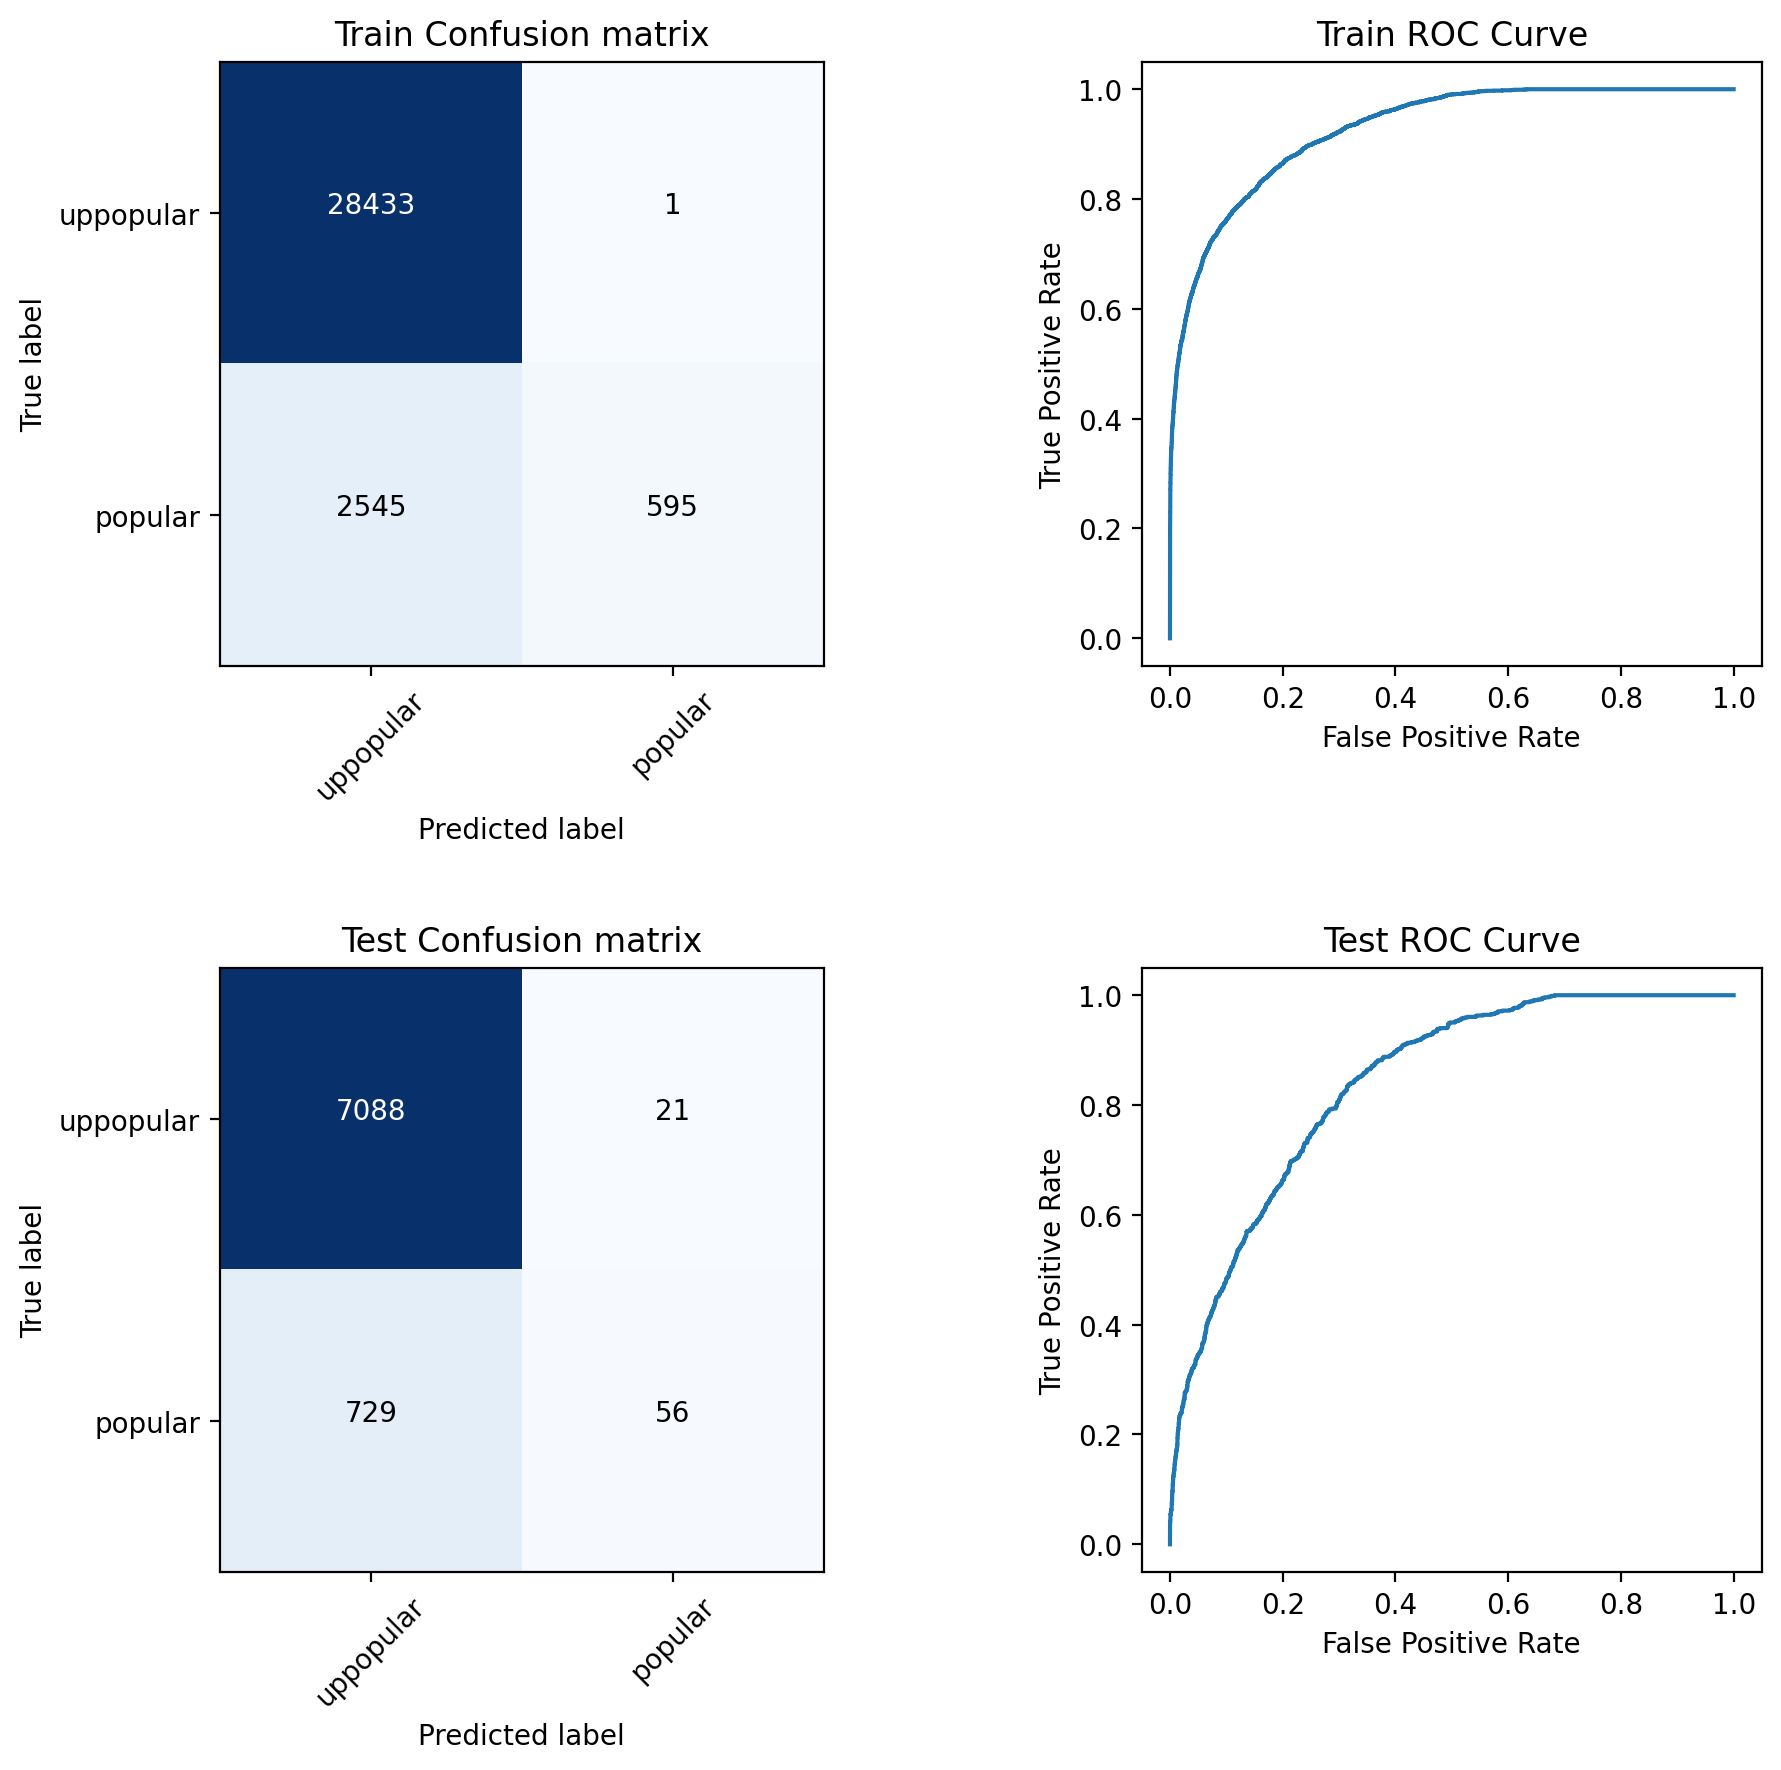

In [4]:
model = make_model(X_train,y_train)
test_model(model,(X_train, X_test), (y_train, y_test),print_score=False,plots=True)

# Optimization
In order to optimize the model there are three main ways we can change the set up
 - limiting points: in the exploritory models, these points were equalized evenly, maybe we could try limit points but in a way that still emulates the imbalance
 - parameter tuning: Use the f1_score to fine tune model parameters.
 - determining theshold: Since the dataset is so imbalanced changing the probability threshold might help increase the score.

## Limiting Points
There are almost 10 time more unpopular articles to popular articles. This portion stives to find whether a certain ratio between these two lables in the training dataset helps fix the imbalance. 

Make 10 simple models with different ratios of lables ranging between 1:1 to no ratio.

In [19]:
def find_best_lim(X,y, ratio_range=range(0,10),print_values=False,p_thresh=0.70):
    ''' Finds and returns the the best ratio of unpopular to popular articles in the training set.'''
    limited_points_scores = pd.DataFrame()
    if type(X) == tuple:
        for i in range(0,10):
            for k in ratio_range:
                X_train_lim, X_test_lim, y_train_lim, y_test_lim = lim_entries(X,y,i=k)
                model = make_model(X_train_lim,y_train_lim)
                accuracy = test_model(model,(X_train_lim, X_test_lim), (y_train_lim, y_test_lim),print_score=False)
                limited_points_scores = limited_points_scores.append(accuracy.rename(index={0:k}))
                
    else:
        for i in range(0,10):
            for k in ratio_range:
                X_lim, y_lim = lim_entries(X,y,i=k)
                model = make_model(X_lim, y_lim )
                accuracy = test_model(model,X_lim, y_lim, print_score=False)
                limited_points_scores = limited_points_scores.append(accuracy.rename(index={0:k}))

    limited_points_scores = limited_points_scores.reset_index().groupby('index').mean()
    lim = limited_points_scores[limited_points_scores.precision >= p_thresh].sort_values('f1_score',ascending=False)
    best_ratio = list(lim.head().index)[0]
    
    if print_values==True:
        print('Top Five Ratios')
        print(limited_points_scores.sort_values('precision',ascending=False).head(5).round(3))
        print('Best Ratio:', best_ratio)
        
    return best_ratio
        
best_ratio = find_best_lim((X_train, X_test), (y_train, y_test), ratio_range=range(0,10),print_values=True)

It seems that limiting the ratio 9 unpopular to 1 popular article provides the best f1_score of the higher precision models. 

I'll split the data accordingly

In [6]:
# split based on selected limit ratio
X_train, X_test, y_train, y_test = lim_entries((X_train, X_test), (y_train, y_test),i=best_ratio,print_y=True)

## Hyperparameter tuning

Used gridsearchCV to determine the best max depth and n estimators using the f1 score to determine the best model.

Parameters:

max_depth - 10, 12, 14, 16, 18, 20, 22, 24

n_estimators - 50, 100, 150, 200

In [10]:
# set up the params grid
grid_params = {'random_forest__max_depth':range(10,25,2),'random_forest__n_estimators':[50,100,150,200]}

# Use gridsearchCV scoring on the f1 score
best = best_params(X_train,y_train,grid_params,score='f1')
print(best)

model = make_model(X_train,y_train,best['random_forest__max_depth'],best['random_forest__n_estimators'])
#test_model(model, , plots=True, print_score=False)

{'random_forest__max_depth': 22, 'random_forest__n_estimators': 200}


## Choosing a Threshold

Determine the best probability threshold from the values 0.3, 0.4, 0.5, 0.6, and 0.7.

In [11]:
y_pred_proba = model.predict_proba(X_test)[:, 1]

def find_best_threshold(y_proba, y, threshold=[x/10 for x in range(3,8)], p_thresh=0.65):
    '''Finds and returns the best threshold for the model'''
    prediction_scores = pd.DataFrame()
    for n in threshold:
        y_pred =  predict(y_pred_proba, n)
        scores = precision_recall_fscore_support(y_test, y_pred,average='binary')[:3]
        scores = pd.DataFrame({'Precision':[scores[0]],'Recall':[scores[1]],'F Score':[scores[2]]},index=[n])
        prediction_scores = prediction_scores.append(scores)
            
    prediction_scores = prediction_scores[prediction_scores['Precision'] >= p_thresh].sort_values('F Score',ascending=False)
    return prediction_scores.head(1).index[0]

best_thresh = find_best_threshold(y_pred_proba,y_test)

## Optimized Model

   precision    recall  f1_score  accuracy
0   0.725664  0.104459  0.182628  0.909023


,precision,recall,f1_score,accuracy
0,0.725664,0.104459,0.182628,0.909023


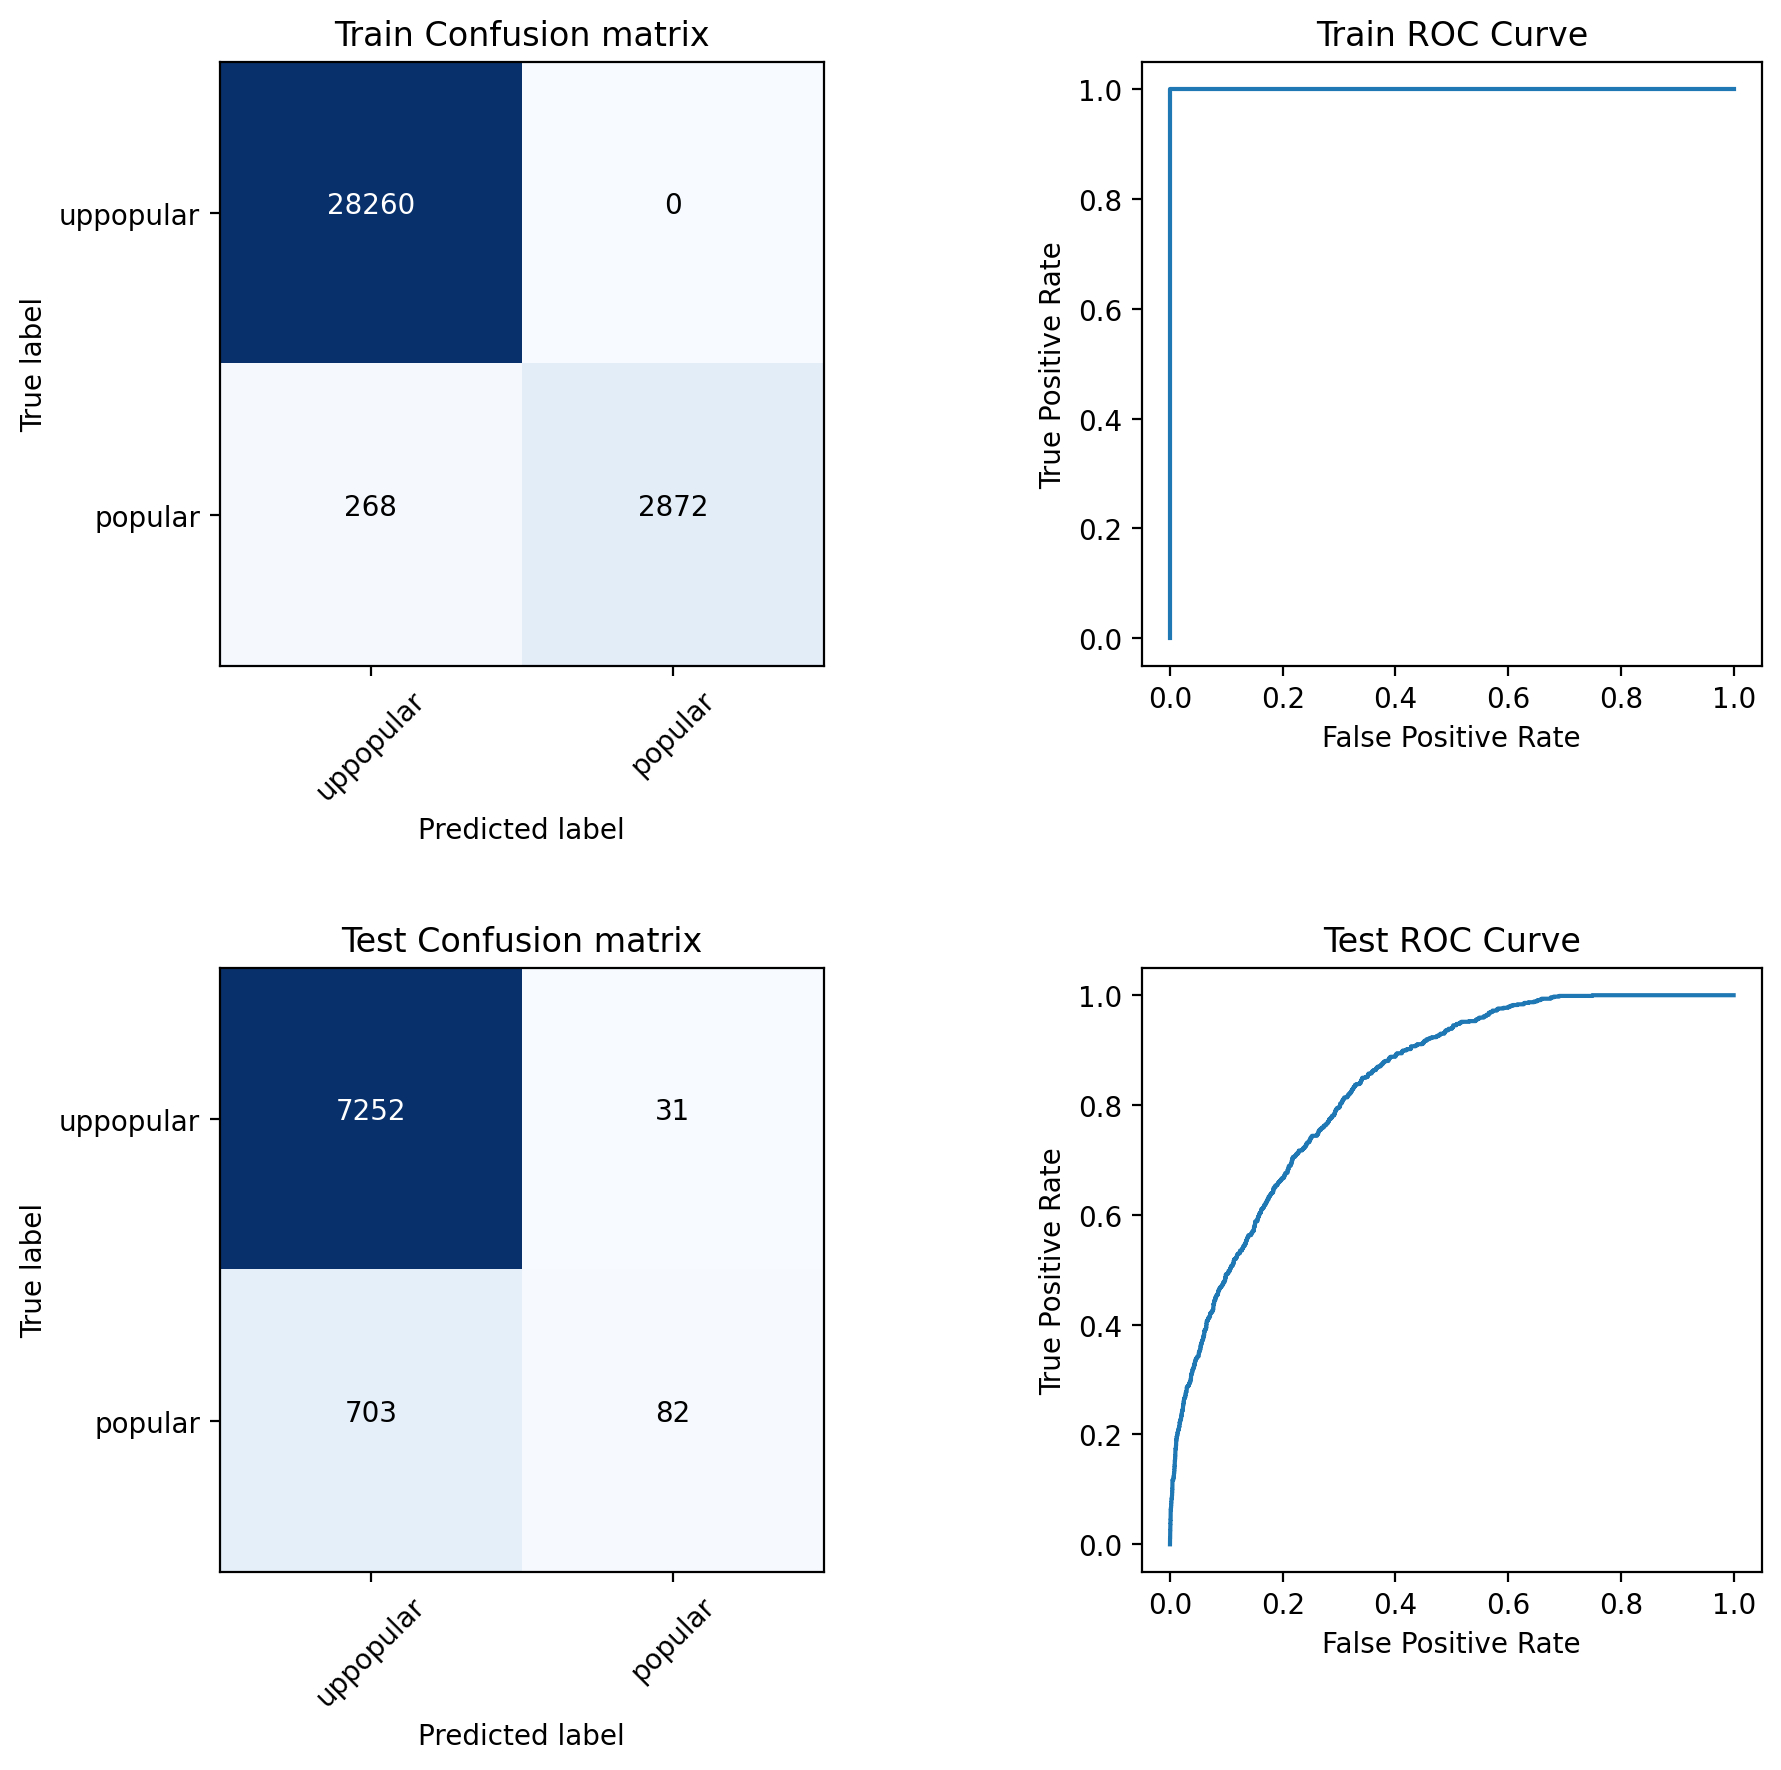

In [12]:
test_model(model, (X_train, X_test), (y_train, y_test), print_score=True,plots=True,thresh=best_thresh)

best training set ratio: 9:1
best max_depth: 22
best n_estimators: 50
Best Probability Threshold: 0.5
   precision    recall  f1_score
0        1.0  0.874395  0.932989


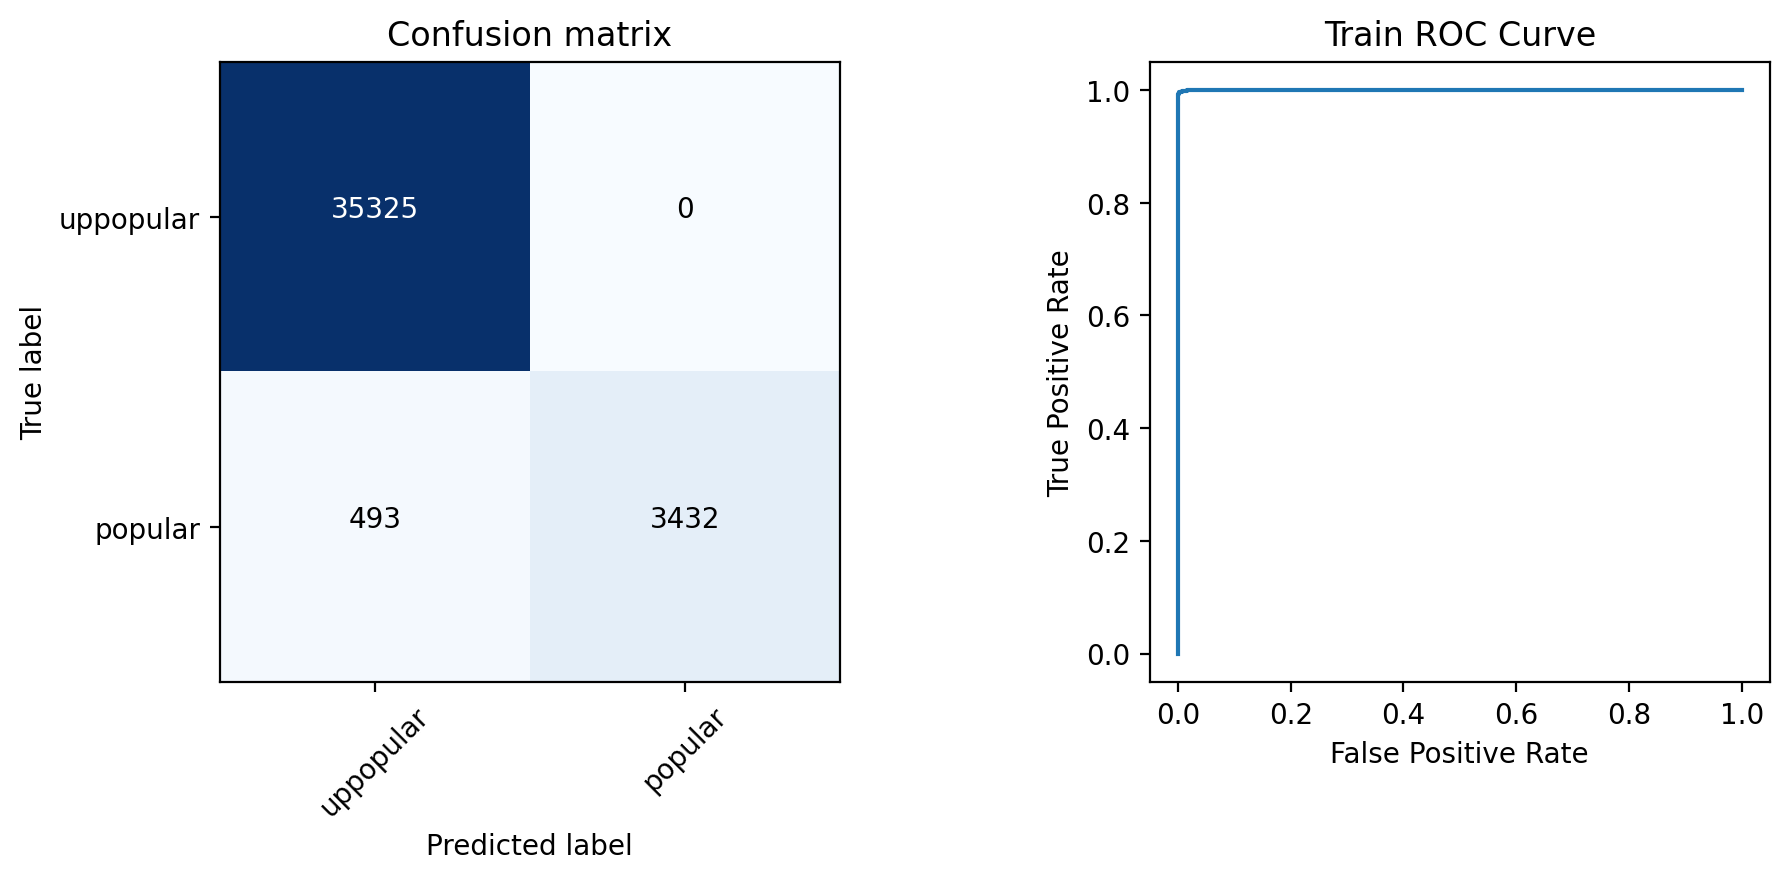

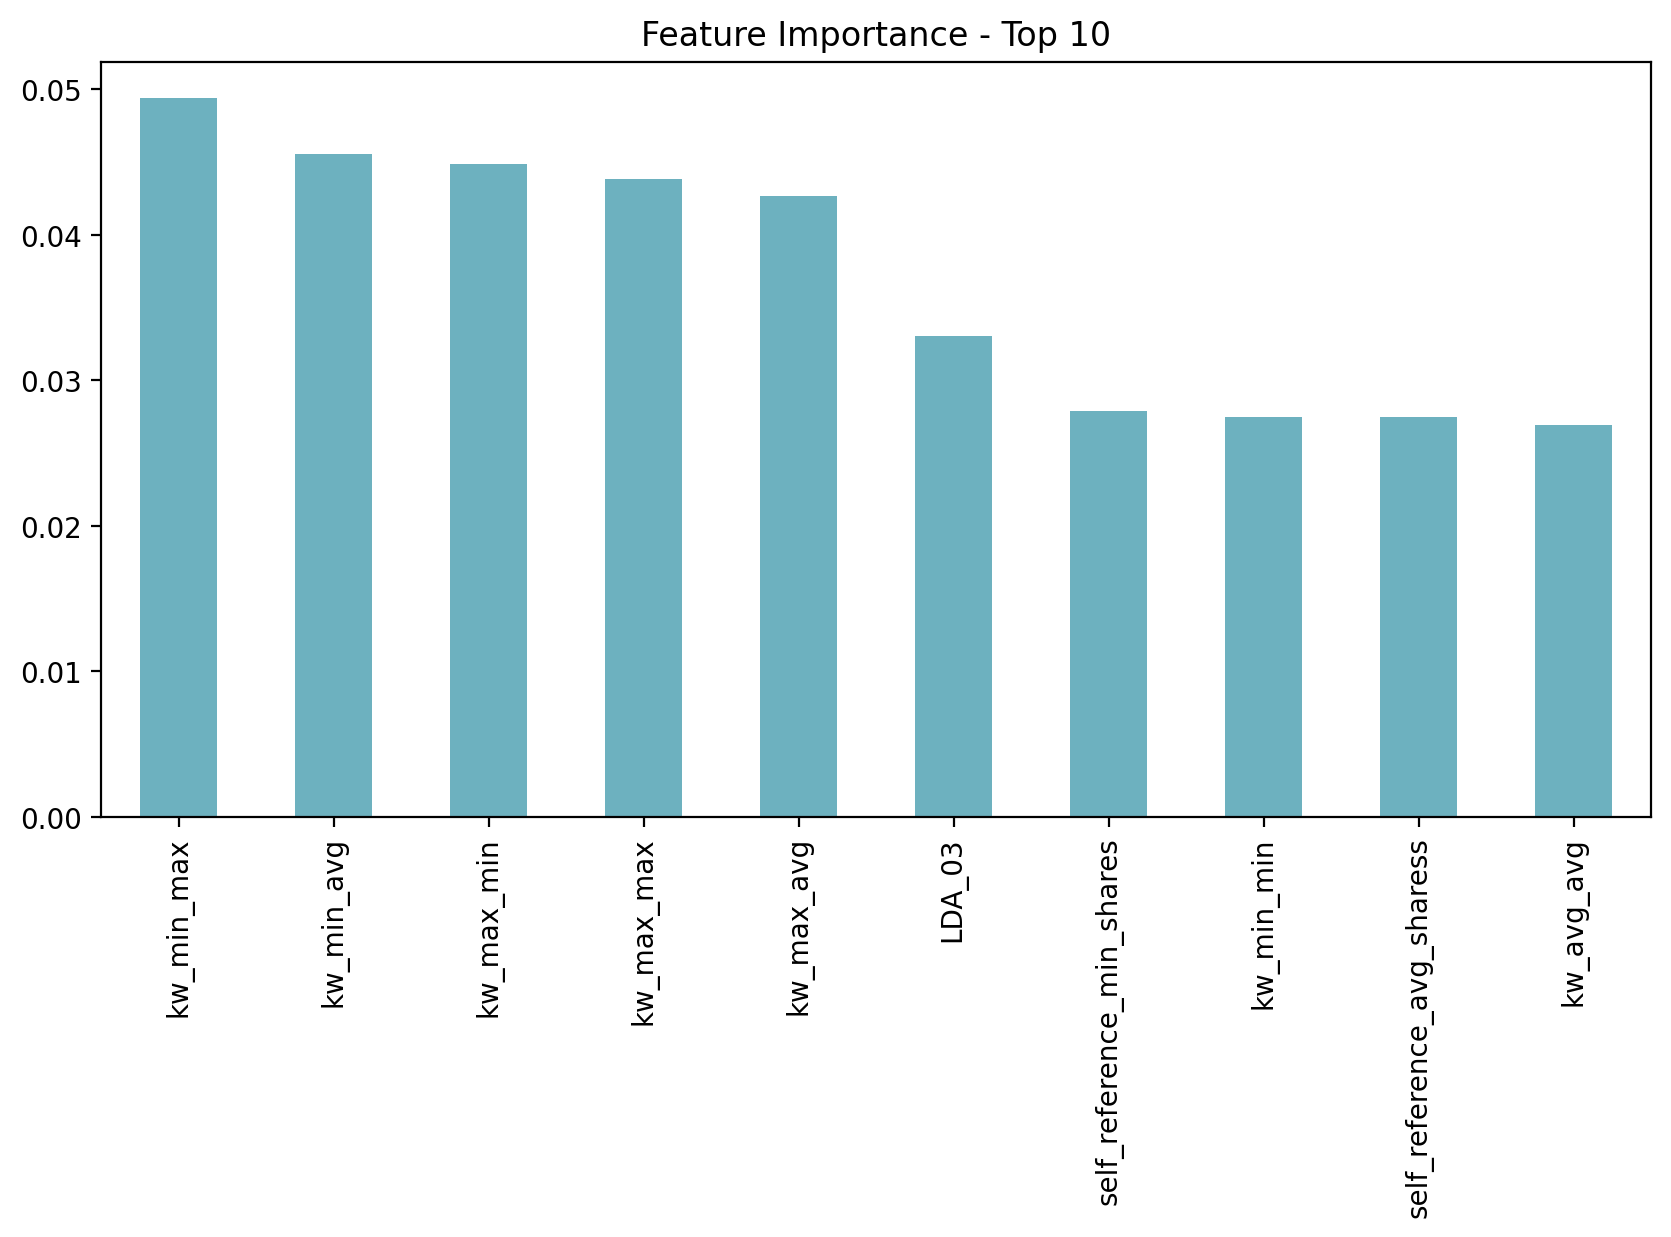

In [24]:
thresh = np.percentile(data.shares,[0,90])[1]

def final_optimization(data,thresh,y_var):
    # Seperate popular and unpopular points
    data = popularity(data,thresh=thresh,col_name=y_var)
    y_var_values = data[y_var].unique()
    X = data.drop(columns=y_var)
    y = data[y_var].replace(y_var_values,range(len(y_var_values)))
    
    # Find the best ratio for the training set
    best_ratio = find_best_lim(X,y,print_values=False,p_thresh=0.99)
    best_ratio_print = str(best_ratio)+':1'
    print('best training set ratio:',best_ratio_print) 
    
    # make final X, y 
    X,y= lim_entries(X,y,i=best_ratio)
        
    # hyperparameters
    grid_params = {'random_forest__max_depth':range(10,25),'random_forest__n_estimators':[50,100,150]}
    best = best_params(X,y,grid_params,score='f1')
    print('best max_depth:',best['random_forest__max_depth'])
    print('best n_estimators:',best['random_forest__n_estimators'])
    
    # make model
    model = make_model(X,y,best['random_forest__max_depth'],best['random_forest__n_estimators'])
    
    # Find the best threshold
    prob_threshold = find_best_threshold(y_pred_proba,y_test)
    print('Best Probability Threshold:',prob_threshold)
    
    test_model(model,X,y, plots=True, print_score=True,feat_importance=True)
               
final_optimization(data.copy(),thresh,'popularity')